# Import modules

In [1]:
import h5py
import json
import random
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras import Sequential
from tensorflow.keras import mixed_precision
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPooling2D, Dropout

# Optimize performance

In [2]:
mixed_precision.set_global_policy('mixed_float16')

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 3060 Ti, compute capability 8.6


# Open hdf5 dataset structure

In [3]:
# Open dataset
with h5py.File(r'C:\Users\edfli\Downloads\brain_tumor_dataset\dataset_training.h5', 'r') as hdf5_file:
    images = hdf5_file["images"][:]
    labels = hdf5_file["labels"][:]
print(images.shape, labels.shape)

(2870, 256, 256, 3) (2870,)


# Split data into train and test split with 80-20 proportion

In [4]:
images_training, images_testing, labels_training, labels_testing = train_test_split(images, labels, test_size=0.2)
print(images_training.shape, labels_training.shape)
print(images_testing.shape, labels_testing.shape)

(2296, 256, 256, 3) (2296,)
(574, 256, 256, 3) (574,)


# Define classes

In [5]:
classes = {0 : 'glioma_tumor',
           1 : 'meningioma_tumor',
           2 : 'normal',
           3 : 'pituitary_tumor'}

# Show images examples

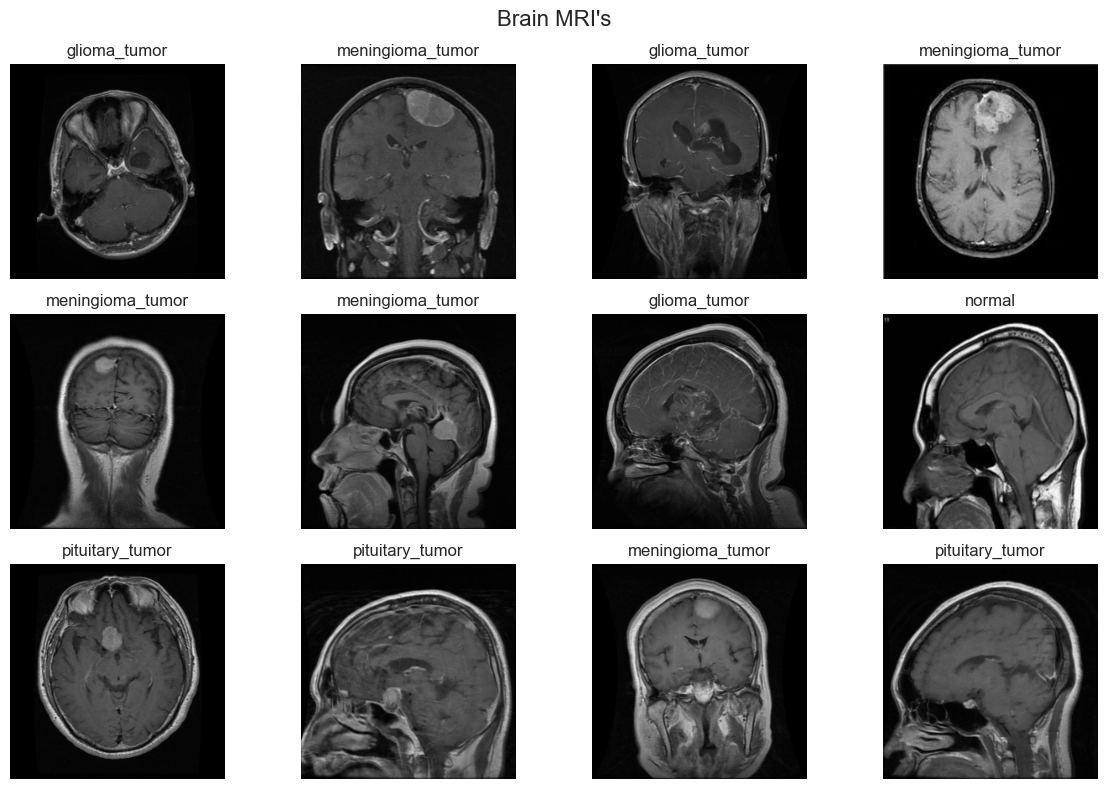

In [9]:
# Create a grid of pie charts
fig, axs = plt.subplots(3, 4, figsize=(12, 8))

# Flatten the axis array for easy iteration
axs = axs.ravel()

for i in range(12):
    index_random = random.randint(0,images_training.shape[0])
    axs[i].imshow(images_training[index_random])
    axs[i].axis('off')
    axs[i].set_title(classes[labels_training[index_random]])
    #axs[i].grid()
fig.suptitle('Brain MRI\'s', fontsize=16)
plt.tight_layout()
#plt.grid()
plt.savefig('images/examples_Brain_MRIs.png', dpi=300, bbox_inches='tight')


plt.show()

# Functions to eval performance and save models

## Plot history loss and accuracy

In [10]:
def plot_history(historical):
  epochs = range(1, len(historical.history['loss'])+1)

  plt.figure(figsize = (12,4))


  plt.subplot(1,2,1)
  plt.plot(epochs, historical.history['loss'], label = 'Trainning loss')
  plt.plot(epochs, historical.history['val_loss'], label = 'validation loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.title('Trainning and validation loss')
  plt.legend()

  plt.subplot(1,2,2)
  plt.plot(epochs, historical.history['accuracy'], label = 'Trainning accuracy')
  plt.plot(epochs, historical.history['val_accuracy'], label = 'validation accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('accuracy')
  plt.title('Trainning and validation accuracy')
  plt.legend()
  plt.ylim(0, 1.1)

## Plot confusion matrix and display classification report

In [11]:
def confusionMatrix_and_Report(y_pred, y_test, labels):
  cm = confusion_matrix(y_test, y_pred, )
  #print(type(cm), cm)
  cm = pd.DataFrame(cm,  range(4),range(4))
  x_axis_labels = labels
  y_axis_labels = labels
  plt.figure(figsize = (6,6))
  ax = sns.heatmap(cm, annot=True, fmt='g', annot_kws={"size": 12}, xticklabels=x_axis_labels, yticklabels=y_axis_labels, cbar=False) # font size
  ax.xaxis.tick_top() # x axis on top
  ax.xaxis.set_label_position('top')
  plt.show()

  reporte = classification_report(y_test, y_pred, target_names = labels)
  print(reporte)

## Save model and history

In [12]:
def save_model_and_store_history(model, history, name):
    try:
        model.save('Saved_models_and_history/'+name)
        history_dict = {'accuracy': history.history['accuracy'],
                        'loss': history.history['loss'],
                        'val_accuracy' : history.history['val_accuracy'],
                        'val_loss' : history.history['val_loss']
                        }
        with open('Saved_models_and_history/'+name+'_history.json', 'w') as json_file:
            json.dump(history_dict, json_file)
    except:
        print('The folder to store the model and the history does not exists, please create it before run save_model_and_store_history')

# Define data Augmentation block

In [13]:
# Define data augmentation layers
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal", input_shape=(256,256,3)),  # Horizontal flip
    tf.keras.layers.experimental.preprocessing.RandomRotation(factor=0.05),  # Random rotation up to 30 degrees
    tf.keras.layers.experimental.preprocessing.RandomZoom(height_factor=0.1, width_factor=0.1),  # Random zoom up to 15%
    tf.keras.layers.experimental.preprocessing.RandomTranslation(height_factor=.15, width_factor=.15),  # Random shear up to 20%
    tf.keras.layers.experimental.preprocessing.Rescaling(1.0 / 255.0, input_shape=(256, 256, 3))
])

# Define models

## Define transfer learning models
* Import VGG16, ResNet50v2, InceptionResNetV2, MobileNetV2
* Turn off trainable parameter in each layer
* Add own fully connected layers

### VGG16

In [14]:
vgg_16 = keras.applications.VGG16(weights='imagenet', include_top = False, input_shape=(256,256,3))

for layer in vgg_16.layers:
  layer.trainable = False

custom_vgg16 = Sequential()

#Preprocessing layers
custom_vgg16.add(data_augmentation)

custom_vgg16.add(vgg_16)
custom_vgg16.add(Flatten())
custom_vgg16.add(Dense(64, activation = 'relu'))
custom_vgg16.add(Dense(128, activation = 'relu'))
custom_vgg16.add(Dense(4, activation = 'softmax'))


custom_vgg16.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.001),
                           #optimizer = tf.keras.optimizers.SGD(learning_rate = 0.01, nesterov=True),
                           #loss = tf.keras.losses.BinaryCrossentropy(from_logits=False,name='binary_crossentropy'),
                           loss = tf.keras.losses.CategoricalCrossentropy(from_logits=False),
                           metrics = ['accuracy'])

custom_vgg16.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 256, 256, 3)       0         
_________________________________________________________________
vgg16 (Functional)           (None, 8, 8, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 32768)             0         
_________________________________________________________________
dense (Dense)                (None, 64)                2097216   
_________________________________________________________________
dense_1 (Dense)              (None, 128)               8320      
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 516       
Total params: 16,820,740
Trainable params: 2,106,052
Non-trainable params: 14,714,688
__________________________________

### ResNet50v2

In [15]:
ResNet50v2 = keras.applications.ResNet50V2(weights='imagenet', include_top = False, input_shape=(256,256,3))

for layer in ResNet50v2.layers:
  layer.trainable = False

ResNet50v2_custom = Sequential()

#Preprocessing layers
ResNet50v2_custom.add(data_augmentation)

ResNet50v2_custom.add(ResNet50v2)
ResNet50v2_custom.add(Flatten())
ResNet50v2_custom.add(Dense(64, activation = 'relu'))
ResNet50v2_custom.add(Dense(128, activation = 'relu'))
ResNet50v2_custom.add(Dense(4, activation = 'softmax'))


ResNet50v2_custom.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.001),
                           #optimizer = tf.keras.optimizers.SGD(learning_rate = 0.01, nesterov=True),
                           #loss = tf.keras.losses.BinaryCrossentropy(from_logits=False,name='binary_crossentropy'),
                           loss = tf.keras.losses.CategoricalCrossentropy(from_logits=False),
                           metrics = ['accuracy'])

ResNet50v2_custom.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 256, 256, 3)       0         
_________________________________________________________________
resnet50v2 (Functional)      (None, 8, 8, 2048)        23564800  
_________________________________________________________________
flatten_1 (Flatten)          (None, 131072)            0         
_________________________________________________________________
dense_3 (Dense)              (None, 64)                8388672   
_________________________________________________________________
dense_4 (Dense)              (None, 128)               8320      
_________________________________________________________________
dense_5 (Dense)              (None, 4)                 516       
Total params: 31,962,308
Trainable params: 8,397,508
Non-trainable params: 23,564,800
__________________________________

### InceptionResNetv2

In [16]:
InceptionResNetv2 = keras.applications.InceptionResNetV2(weights='imagenet', include_top = False, input_shape=(256,256,3))

for layer in InceptionResNetv2.layers:
  layer.trainable = False

InceptionResNetv2_custom = Sequential()

#Preprocessing layers
InceptionResNetv2_custom.add(data_augmentation)

InceptionResNetv2_custom.add(InceptionResNetv2)
InceptionResNetv2_custom.add(Flatten())
InceptionResNetv2_custom.add(Dense(64, activation = 'relu'))
InceptionResNetv2_custom.add(Dense(128, activation = 'relu'))
InceptionResNetv2_custom.add(Dense(4, activation = 'softmax'))


InceptionResNetv2_custom.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.001),
                           #optimizer = tf.keras.optimizers.SGD(learning_rate = 0.01, nesterov=True),
                           #loss = tf.keras.losses.BinaryCrossentropy(from_logits=False,name='binary_crossentropy'),
                           loss = tf.keras.losses.CategoricalCrossentropy(from_logits=False),
                           metrics = ['accuracy'])

InceptionResNetv2_custom.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 256, 256, 3)       0         
_________________________________________________________________
inception_resnet_v2 (Functio (None, 6, 6, 1536)        54336736  
_________________________________________________________________
flatten_2 (Flatten)          (None, 55296)             0         
_________________________________________________________________
dense_6 (Dense)              (None, 64)                3539008   
_________________________________________________________________
dense_7 (Dense)              (None, 128)               8320      
_________________________________________________________________
dense_8 (Dense)              (None, 4)                 516       
Total params: 57,884,580
Trainable params: 3,547,844
Non-trainable params: 54,336,736
__________________________________

### MobileNetv2

In [17]:
MobileNetv2 = keras.applications.MobileNetV2(weights='imagenet', include_top = False, input_shape=(256,256,3))

for layer in MobileNetv2.layers:
  layer.trainable = False

MobileNetv2_custom = Sequential()

#Preprocessing layers
MobileNetv2_custom.add(data_augmentation)

MobileNetv2_custom.add(MobileNetv2)
MobileNetv2_custom.add(Flatten())
MobileNetv2_custom.add(Dense(64, activation = 'relu'))
MobileNetv2_custom.add(Dense(128, activation = 'relu'))
MobileNetv2_custom.add(Dense(4, activation = 'softmax'))


MobileNetv2_custom.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.001),
                           #optimizer = tf.keras.optimizers.SGD(learning_rate = 0.01, nesterov=True),
                           #loss = tf.keras.losses.BinaryCrossentropy(from_logits=False,name='binary_crossentropy'),
                           loss = tf.keras.losses.CategoricalCrossentropy(from_logits=False),
                           metrics = ['accuracy'])

MobileNetv2_custom.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 256, 256, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 8, 8, 1280)        2257984   
_________________________________________________________________
flatten_3 (Flatten)          (None, 81920)             0         
_________________________________________________________________
dense_9 (Dense)              (None, 64)                5242944   
_________________________________________________________________
dense_10 (Dense)             (None, 128)               8320      
_________________________________________________________________
dense_11 (Dense)             (None, 4)                 516       
Total params: 7,509,764
Trainable params: 5,251,780
Non-trainable params: 2,257,984
____________________________________

## Define simple CNN model

In [37]:
simple_CNN = Sequential()

simple_CNN.add(Conv2D(128, (3, 3), input_shape=( 256, 256, 3), activation='relu'))
simple_CNN.add(MaxPooling2D(pool_size=(2, 2)))

simple_CNN.add(Conv2D(128, (3, 3), activation='relu'))
simple_CNN.add(MaxPooling2D(pool_size=(2, 2)))

simple_CNN.add(Conv2D(128, (3, 3), activation='relu'))
simple_CNN.add(MaxPooling2D(pool_size=(2, 2)))

simple_CNN.add(Flatten())

simple_CNN.add(Dense(128, activation='relu'))
simple_CNN.add(Dropout(0.33))

simple_CNN.add(Dense(256, activation = 'relu'))
simple_CNN.add(Dropout(0.5))

simple_CNN.add(Dense(4, activation = 'softmax'))


simple_CNN.compile(#loss='sparse_categorical_crossentropy',
                loss = tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              optimizer= "adam",
              metrics=['accuracy'],
              )

simple_CNN.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_206 (Conv2D)          (None, 254, 254, 128)     3584      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 127, 127, 128)     0         
_________________________________________________________________
conv2d_207 (Conv2D)          (None, 125, 125, 128)     147584    
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 62, 62, 128)       0         
_________________________________________________________________
conv2d_208 (Conv2D)          (None, 60, 60, 128)       147584    
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 30, 30, 128)       0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 115200)           

# Train models

## VGG16

### Train VGG16

Epoch 1/20
58/58 [==============================] - 9s 87ms/step - loss: 1.3057 - accuracy: 0.5191 - val_loss: 0.6943 - val_accuracy: 0.7239
Epoch 2/20
58/58 [==============================] - 5s 81ms/step - loss: 0.6859 - accuracy: 0.7217 - val_loss: 0.6422 - val_accuracy: 0.7630
Epoch 3/20
58/58 [==============================] - 5s 81ms/step - loss: 0.5785 - accuracy: 0.7680 - val_loss: 0.6414 - val_accuracy: 0.7674
Epoch 4/20
58/58 [==============================] - 5s 82ms/step - loss: 0.4978 - accuracy: 0.8115 - val_loss: 0.5065 - val_accuracy: 0.8043
Epoch 5/20
58/58 [==============================] - 5s 81ms/step - loss: 0.4836 - accuracy: 0.8034 - val_loss: 0.8663 - val_accuracy: 0.6935
Epoch 6/20
58/58 [==============================] - 5s 88ms/step - loss: 0.4692 - accuracy: 0.8170 - val_loss: 0.5632 - val_accuracy: 0.8022
Epoch 7/20
58/58 [==============================] - 5s 81ms/step - loss: 0.3857 - accuracy: 0.8426 - val_loss: 0.4736 - val_accuracy: 0.8239
Epoch 8/20
58

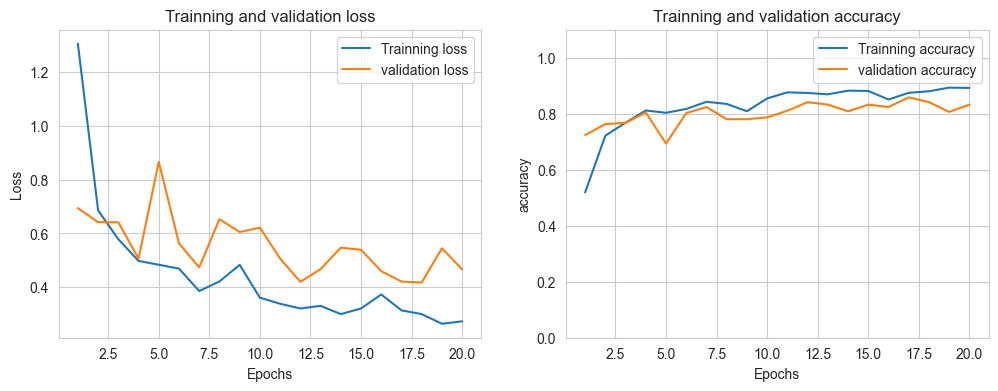

In [19]:
historical_custom_vgg16 = custom_vgg16.fit(x = images_training,
                                    y = to_categorical(labels_training),
                                    epochs = 20,
                                    batch_size = 32,
                                    #validation_data = (images_validation, to_categorical(labels_validation)),
                                    validation_split=.2,
                                    )
plot_history(historical_custom_vgg16)

### Evaluate VGG16 on testing data split

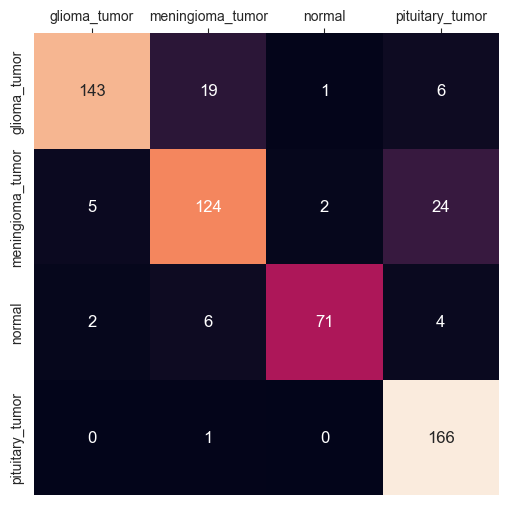

                  precision    recall  f1-score   support

    glioma_tumor       0.95      0.85      0.90       169
meningioma_tumor       0.83      0.80      0.81       155
          normal       0.96      0.86      0.90        83
 pituitary_tumor       0.83      0.99      0.90       167

        accuracy                           0.88       574
       macro avg       0.89      0.87      0.88       574
    weighted avg       0.88      0.88      0.88       574


In [20]:
y_pred_custom_vgg16 = custom_vgg16.predict(images_testing)
y_pred_custom_vgg16 = np.argmax(y_pred_custom_vgg16, axis = 1)
confusionMatrix_and_Report(y_pred_custom_vgg16, labels_testing, list(classes.values()))

### Save model and history in disk, delete the from memory to free space to next model 

In [21]:
save_model_and_store_history(custom_vgg16, historical_custom_vgg16, 'custom_vgg16')
del custom_vgg16, historical_custom_vgg16

INFO:tensorflow:Assets written to: Saved_models_and_history/custom_vgg16\assets


## ResNet50v2

### Train ResNet50v2

Epoch 1/20
58/58 [==============================] - 5s 53ms/step - loss: 3.6066 - accuracy: 0.5594 - val_loss: 1.0249 - val_accuracy: 0.7630
Epoch 2/20
58/58 [==============================] - 2s 42ms/step - loss: 0.7348 - accuracy: 0.7968 - val_loss: 0.5108 - val_accuracy: 0.8261
Epoch 3/20
58/58 [==============================] - 2s 42ms/step - loss: 0.5069 - accuracy: 0.8333 - val_loss: 0.5280 - val_accuracy: 0.8174
Epoch 4/20
58/58 [==============================] - 2s 42ms/step - loss: 0.4734 - accuracy: 0.8415 - val_loss: 0.6390 - val_accuracy: 0.7652
Epoch 5/20
58/58 [==============================] - 2s 42ms/step - loss: 0.4009 - accuracy: 0.8546 - val_loss: 0.4851 - val_accuracy: 0.8283
Epoch 6/20
58/58 [==============================] - 2s 42ms/step - loss: 0.3426 - accuracy: 0.8764 - val_loss: 0.5543 - val_accuracy: 0.8304
Epoch 7/20
58/58 [==============================] - 2s 42ms/step - loss: 0.3571 - accuracy: 0.8704 - val_loss: 0.6708 - val_accuracy: 0.8326
Epoch 8/20
58

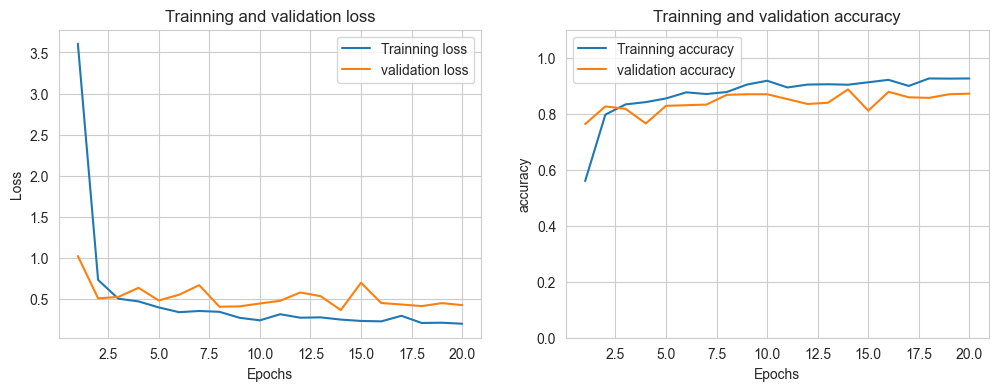

In [22]:
historical_ResNet50v2 = ResNet50v2_custom.fit(x = images_training,
                                    y = to_categorical(labels_training),
                                    epochs = 20,
                                    batch_size = 32,
                                    #validation_data = (images_validation, to_categorical(labels_validation)),
                                    validation_split=.2,
                                    )
plot_history(historical_ResNet50v2)

### Evaluate ResNet50v2 on testing data split

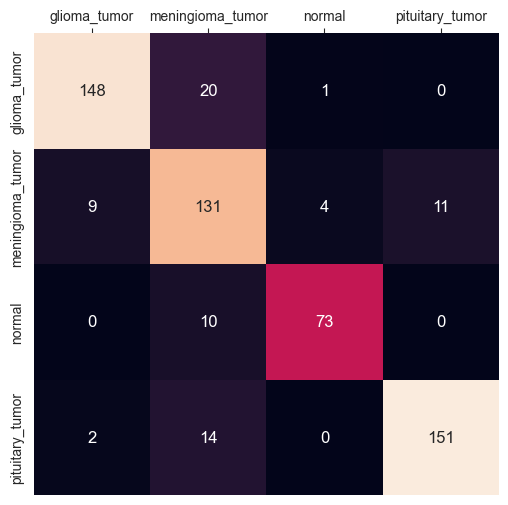

                  precision    recall  f1-score   support

    glioma_tumor       0.93      0.88      0.90       169
meningioma_tumor       0.75      0.85      0.79       155
          normal       0.94      0.88      0.91        83
 pituitary_tumor       0.93      0.90      0.92       167

        accuracy                           0.88       574
       macro avg       0.89      0.88      0.88       574
    weighted avg       0.88      0.88      0.88       574


In [23]:
y_pred_resnet = ResNet50v2_custom.predict(images_testing)
y_pred_resnet = np.argmax(y_pred_resnet, axis = 1)
confusionMatrix_and_Report(y_pred_resnet, labels_testing, list(classes.values()))

### Save model and history in disk, delete the from memory to free space to next model

In [24]:
save_model_and_store_history(ResNet50v2_custom, historical_ResNet50v2, 'resnet50v2_custom')
del ResNet50v2_custom, historical_ResNet50v2

INFO:tensorflow:Assets written to: Saved_models_and_history/resnet50v2_custom\assets


C:\Users\edfli\anaconda3\envs\brain_p37\lib\site-packages\keras\utils\generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


## InceptionResNETv2

### Train InceptionResNetv2

Epoch 1/20
58/58 [==============================] - 14s 114ms/step - loss: 3.5968 - accuracy: 0.5398 - val_loss: 0.8483 - val_accuracy: 0.7435
Epoch 2/20
58/58 [==============================] - 4s 75ms/step - loss: 0.8897 - accuracy: 0.7042 - val_loss: 0.9951 - val_accuracy: 0.6891
Epoch 3/20
58/58 [==============================] - 4s 75ms/step - loss: 0.6244 - accuracy: 0.7712 - val_loss: 0.5651 - val_accuracy: 0.8043
Epoch 4/20
58/58 [==============================] - 4s 75ms/step - loss: 0.5144 - accuracy: 0.8192 - val_loss: 0.5247 - val_accuracy: 0.8087
Epoch 5/20
58/58 [==============================] - 4s 75ms/step - loss: 0.4464 - accuracy: 0.8361 - val_loss: 0.8059 - val_accuracy: 0.7413
Epoch 6/20
58/58 [==============================] - 5s 79ms/step - loss: 0.5354 - accuracy: 0.8066 - val_loss: 0.4680 - val_accuracy: 0.8457
Epoch 7/20
58/58 [==============================] - 4s 75ms/step - loss: 0.4514 - accuracy: 0.8241 - val_loss: 0.4632 - val_accuracy: 0.8326
Epoch 8/20


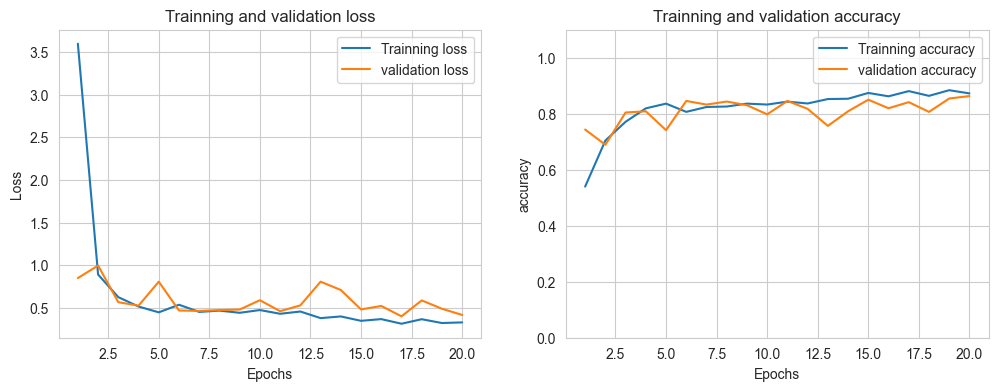

In [25]:
historical_InceptionResNetv2 = InceptionResNetv2_custom.fit(x = images_training,
                                    y = to_categorical(labels_training),
                                    epochs = 20,
                                    batch_size = 32,
                                    #validation_data = (images_validation, to_categorical(labels_validation)),
                                    validation_split=.2,
                                    )
plot_history(historical_InceptionResNetv2)

### Evaluate InceptionResNetv2 on testing data split

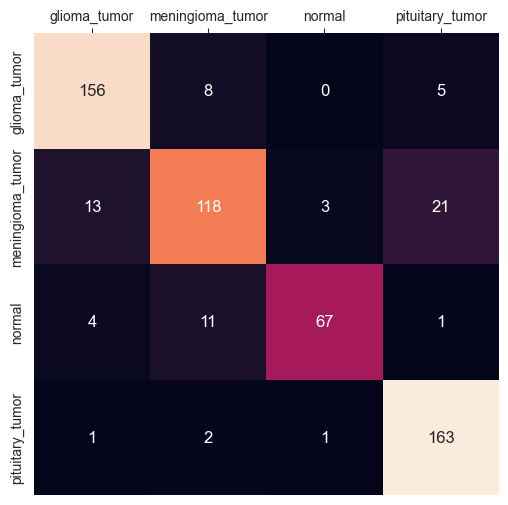

                  precision    recall  f1-score   support

    glioma_tumor       0.90      0.92      0.91       169
meningioma_tumor       0.85      0.76      0.80       155
          normal       0.94      0.81      0.87        83
 pituitary_tumor       0.86      0.98      0.91       167

        accuracy                           0.88       574
       macro avg       0.89      0.87      0.87       574
    weighted avg       0.88      0.88      0.88       574


In [26]:
y_pred_InceptionResNetv2 = InceptionResNetv2_custom.predict(images_testing)
y_pred_InceptionResNetv2 = np.argmax(y_pred_InceptionResNetv2, axis = 1)
confusionMatrix_and_Report(y_pred_InceptionResNetv2, labels_testing, list(classes.values()))

### Save model and history in disk, delete the from memory to free space to next model

In [27]:
save_model_and_store_history(InceptionResNetv2_custom, historical_InceptionResNetv2, 'InceptionResNetv2_custom')
del InceptionResNetv2_custom, historical_InceptionResNetv2

INFO:tensorflow:Assets written to: Saved_models_and_history/InceptionResNetv2_custom\assets


## MobileNetV2

### Train MobileNetV2

Epoch 1/20
58/58 [==============================] - 4s 35ms/step - loss: 2.0398 - accuracy: 0.6367 - val_loss: 1.5447 - val_accuracy: 0.6587
Epoch 2/20
58/58 [==============================] - 1s 25ms/step - loss: 0.5983 - accuracy: 0.7870 - val_loss: 0.7659 - val_accuracy: 0.7565
Epoch 3/20
58/58 [==============================] - 1s 25ms/step - loss: 0.4812 - accuracy: 0.8328 - val_loss: 0.5743 - val_accuracy: 0.7957
Epoch 4/20
58/58 [==============================] - 1s 25ms/step - loss: 0.3934 - accuracy: 0.8508 - val_loss: 0.5827 - val_accuracy: 0.7870
Epoch 5/20
58/58 [==============================] - 1s 25ms/step - loss: 0.4321 - accuracy: 0.8475 - val_loss: 0.7087 - val_accuracy: 0.7891
Epoch 6/20
58/58 [==============================] - 1s 25ms/step - loss: 0.3644 - accuracy: 0.8606 - val_loss: 0.9501 - val_accuracy: 0.7630
Epoch 7/20
58/58 [==============================] - 1s 25ms/step - loss: 0.3463 - accuracy: 0.8764 - val_loss: 0.7315 - val_accuracy: 0.7848
Epoch 8/20
58

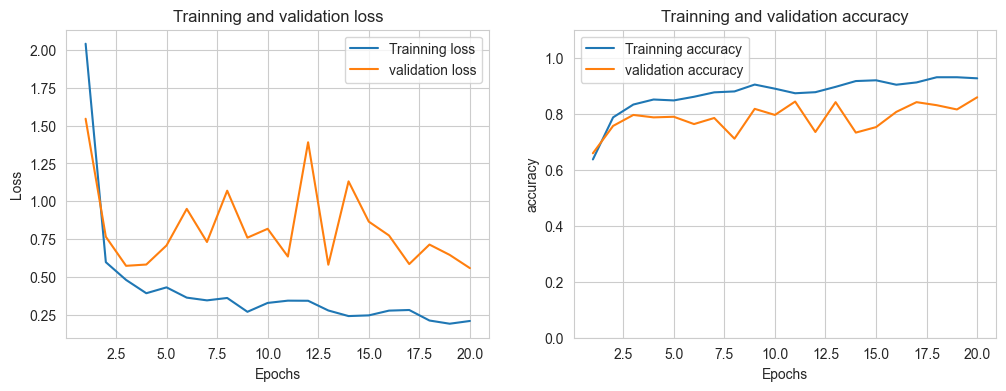

In [28]:
historical_MobileNetv2 = MobileNetv2_custom.fit(x = images_training,
                                    y = to_categorical(labels_training),
                                    epochs = 20,
                                    batch_size = 32,
                                    #validation_data = (images_validation, to_categorical(labels_validation)),
                                    validation_split=.2,
                                    )
plot_history(historical_MobileNetv2)

### Evaluate MobileNetV2 on testing data split

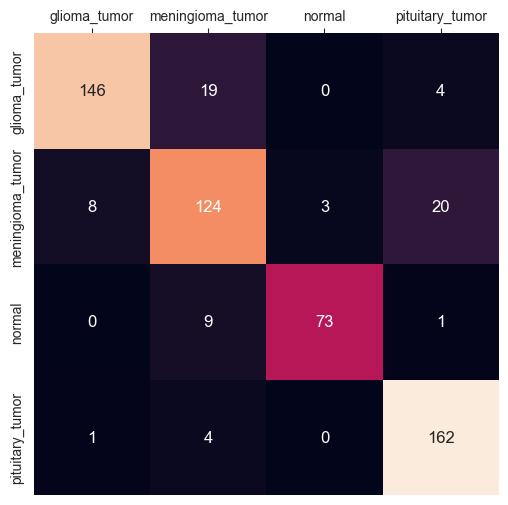

                  precision    recall  f1-score   support

    glioma_tumor       0.94      0.86      0.90       169
meningioma_tumor       0.79      0.80      0.80       155
          normal       0.96      0.88      0.92        83
 pituitary_tumor       0.87      0.97      0.92       167

        accuracy                           0.88       574
       macro avg       0.89      0.88      0.88       574
    weighted avg       0.88      0.88      0.88       574


In [29]:
y_pred_MobileNetv2 = MobileNetv2_custom.predict(images_testing)
y_pred_MobileNetv2 = np.argmax(y_pred_MobileNetv2, axis = 1)
confusionMatrix_and_Report(y_pred_MobileNetv2, labels_testing, list(classes.values()))

### Save model and history in disk, delete the from memory to free space to next model

In [30]:
save_model_and_store_history(MobileNetv2_custom, historical_MobileNetv2, 'MobileNetv2_custom')
del MobileNetv2_custom, historical_MobileNetv2

INFO:tensorflow:Assets written to: Saved_models_and_history/MobileNetv2_custom\assets


C:\Users\edfli\anaconda3\envs\brain_p37\lib\site-packages\keras\utils\generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


## Simple CNN model

### Train simple CNN model

Epoch 1/20
58/58 [==============================] - 9s 153ms/step - loss: 12.5005 - accuracy: 0.3736 - val_loss: 1.2377 - val_accuracy: 0.4478
Epoch 2/20
58/58 [==============================] - 9s 148ms/step - loss: 1.0592 - accuracy: 0.5850 - val_loss: 0.9677 - val_accuracy: 0.6652
Epoch 3/20
58/58 [==============================] - 9s 147ms/step - loss: 0.7906 - accuracy: 0.6934 - val_loss: 0.8209 - val_accuracy: 0.6848
Epoch 4/20
58/58 [==============================] - 9s 147ms/step - loss: 0.6934 - accuracy: 0.7228 - val_loss: 0.7287 - val_accuracy: 0.6913
Epoch 5/20
58/58 [==============================] - 8s 147ms/step - loss: 0.6137 - accuracy: 0.7533 - val_loss: 0.7234 - val_accuracy: 0.7261
Epoch 6/20
58/58 [==============================] - 9s 147ms/step - loss: 0.5560 - accuracy: 0.7827 - val_loss: 0.6818 - val_accuracy: 0.7391
Epoch 7/20
58/58 [==============================] - 9s 150ms/step - loss: 0.4636 - accuracy: 0.8219 - val_loss: 0.6216 - val_accuracy: 0.7957
Epoch

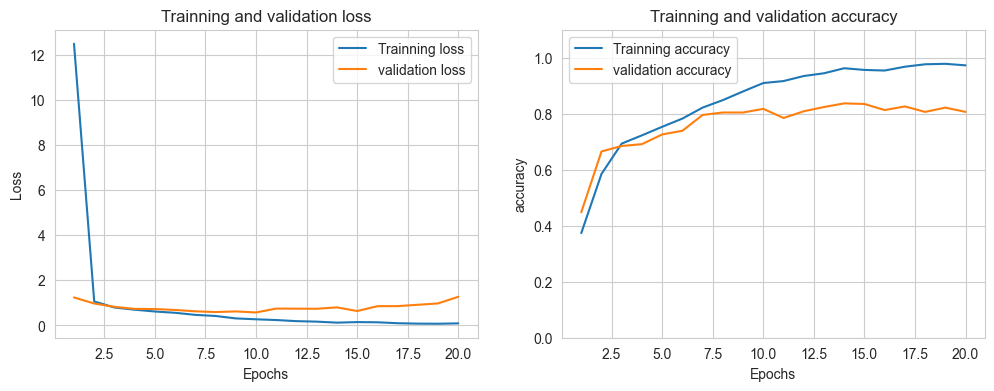

In [38]:
historical_simple_CNN = simple_CNN.fit(x = images_training,
            y = to_categorical(labels_training),
            batch_size=32,
            epochs=20,
            #validation_data = (images_validation, to_categorical(labels_validation)),
            validation_split=.2,
            #callbacks=[tensorboard,es],
            )
plot_history(historical_simple_CNN)

### Evaluate MobileNetV2 on testing data split

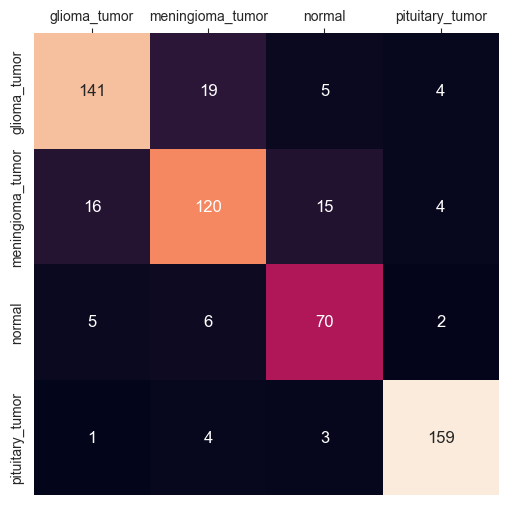

                  precision    recall  f1-score   support

    glioma_tumor       0.87      0.83      0.85       169
meningioma_tumor       0.81      0.77      0.79       155
          normal       0.75      0.84      0.80        83
 pituitary_tumor       0.94      0.95      0.95       167

        accuracy                           0.85       574
       macro avg       0.84      0.85      0.85       574
    weighted avg       0.85      0.85      0.85       574


In [39]:
y_pred_simple_CNN = simple_CNN.predict(images_testing)
y_pred_simple_CNN = np.argmax(y_pred_simple_CNN, axis = 1)
confusionMatrix_and_Report(y_pred_simple_CNN, labels_testing, list(classes.values()))

### Save model and history in disk, delete the from memory to free space to next model

In [40]:
save_model_and_store_history(simple_CNN, historical_simple_CNN, 'simple_CNN')
del simple_CNN, historical_simple_CNN

INFO:tensorflow:Assets written to: Saved_models_and_history/simple_CNN\assets
